# Image Segmentation Projesi  
# Hazırlayan: Musap Yıldız  
# Tarih: 22 Mayıs 2025

Bu notebook’ta sırasıyla:

- 0. Kurulum ve Veri Yükleme  
- A. Veri Analizi
  - A1. Veri Seti Tanıtımı
  - A2. Eksik Veri & Aykırı Değer Analizi
  - A3. Özellik Ayırt Ediciliği
- B. Sınıflama
  - B1. Kullanılan Yöntemler
  - B2. Pipeline & CV
  - B3. Test Sonuçları
- C. Kümeleme
  - C1. Yöntem Tanıtımı
  - C2. Ölçeklendirme & Uygulama
  - C3. Kümelere Etiket Atama
  - C4. Yorum
- D. Sonuç ve Öneriler

In [ ]:
## 0. Kurulum ve Veri Yükleme

# Bu hücrede gerekli kütüphaneler import edilip veri yükleme yapılacaktır.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Sabitler ve veri yolu
DATA_PATH = 'segment.dat'
COLUMNS = [
    'region_centroid_col','region_centroid_row','region_pixel_count',
    'short_line_density_5','short_line_density_2','vedge_mean','vedge_sd',
    'hedge_mean','hedge_sd','intensity_mean','rawred_mean','rawblue_mean',
    'rawgreen_mean','exred_mean','exblue_mean','exgreen_mean',
    'value_mean','saturat_mean','hue_mean','class'
]

# %%
# Veri setini yükleyelim
df = pd.read_csv(DATA_PATH, header=None, names=COLUMNS, sep='\s+')
df.head()


,region_centroid_col,region_centroid_row,region_pixel_count,short_line_density_5,short_line_density_2,vedge_mean,vedge_sd,hedge_mean,hedge_sd,intensity_mean,rawred_mean,rawblue_mean,rawgreen_mean,exred_mean,exblue_mean,exgreen_mean,value_mean,saturat_mean,hue_mean,class
0,218.0,178.0,9,0.111111,0.0,0.833333,0.547722,1.111109,0.544331,59.629630,52.444443,75.222220,51.222220,-21.555555,46.77778,-25.222221,75.222220,0.318996,-2.040554,6
1,113.0,130.0,9,0.000000,0.0,0.277778,0.250924,0.333333,0.365148,0.888889,0.000000,2.555556,0.111111,-2.666667,5.00000,-2.333333,2.555556,1.000000,-2.123254,3
2,202.0,41.0,9,0.000000,0.0,0.944448,0.772202,1.111112,1.025597,123.037040,111.888885,139.777790,117.444440,-33.444443,50.22222,-16.777779,139.777790,0.199347,-2.299918,2
3,32.0,173.0,9,0.000000,0.0,1.722222,1.781593,9.000000,6.749488,43.592594,39.555557,52.888890,38.333336,-12.111111,27.88889,-15.777778,52.888890,0.266914,-1.998857,6
4,61.0,197.0,9,0.000000,0.0,1.444444,1.515353,2.611111,1.925463,49.592594,44.222220,61.555557,43.000000,-16.111110,35.88889,-19.777779,61.555557,0.302925,-2.022274,6


## A. Veri Analizi

### A1. Veri Seti Tanıtımı

Veri setindeki sütunlar ve açıklamaları:

| Sütun               | Açıklama                                 |
|---------------------|------------------------------------------|
| region_centroid_col | Bölgenin yatay merkez koordinatı        |
| region_centroid_row | Bölgenin dikey merkez koordinatı        |
| region_pixel_count  | Bölgedeki piksel sayısı                 |
| short_line_density_5| 5-piksel uzunluğundaki kısa çizgi yoğunluğu |
| short_line_density_2| 2-piksel uzunluğundaki kısa çizgi yoğunluğu |
| vedge_mean          | Dikey kenar yoğunluğu ortalaması        |
| vedge_sd            | Dikey kenar yoğunluğu standart sapması  |
| hedge_mean          | Yatay kenar yoğunluğu ortalaması        |
| hedge_sd            | Yatay kenar yoğunluğu standart sapması  |
| intensity_mean      | Yoğunluk ortalaması                     |
| rawred_mean         | Ham kırmızı kanal ortalaması            |
| rawblue_mean        | Ham mavi kanal ortalaması               |
| rawgreen_mean       | Ham yeşil kanal ortalaması              |
| exred_mean          | Düzenlenmiş kırmızı kanal ortalaması    |
| exblue_mean         | Düzenlenmiş mavi kanal ortalaması       |
| exgreen_mean        | Düzenlenmiş yeşil kanal ortalaması      |
| value_mean          | HSV renk uzayında value ortalaması      |
| saturat_mean        | HSV renk uzayında saturasyon ortalaması |
| hue_mean            | HSV renk uzayında hue ortalaması        |
| class               | Sınıf etiketi (1:SKY, …, 7:WINDOW)       |



In [ ]:
# Temel istatistik ve sınıf dağılımı
print(f"Toplam örnek sayısı: {df.shape[0]}")
print(f"Özellik sayısı (class dahil): {df.shape[1]}")
print(f"Sınıf sayısı: {df['class'].nunique()}")

# Sayısal özet
display(df.describe().T)

# Sınıf isimleri ve dağılım
class_names = {1:'SKY',2:'BUILDING',3:'FOLIAGE',4:'GROUND',5:'ANTENNA',6:'PATH',7:'WINDOW'}
display(df['class'].map(class_names).value_counts())

Toplam örnek sayısı: 2310
Özellik sayısı (class dahil): 20
Sınıf sayısı: 7


,count,mean,std,min,25%,50%,75%,max
region_centroid_col,2310.0,124.913853,72.956532,1.000000e+00,62.000000,121.000000,189.000000,254.000000
region_centroid_row,2310.0,123.417316,57.483851,1.100000e+01,81.000000,122.000000,172.000000,251.000000
region_pixel_count,2310.0,9.000000,0.000000,9.000000e+00,9.000000,9.000000,9.000000,9.000000
short_line_density_5,2310.0,0.014334,0.040154,0.000000e+00,0.000000,0.000000,0.000000,0.333333
short_line_density_2,2310.0,0.004714,0.024234,0.000000e+00,0.000000,0.000000,0.000000,0.222222
vedge_mean,2310.0,1.893939,2.698908,0.000000e+00,0.722222,1.222224,2.166667,29.222221
vedge_sd,2310.0,5.709320,44.846457,0.000000e+00,0.355555,0.833333,1.806367,991.718400
hedge_mean,2310.0,2.424723,3.610084,0.000000e+00,0.777780,1.444444,2.555556,44.722225
hedge_sd,2310.0,8.243692,58.811517,-1.589457e-08,0.421637,0.962963,2.183269,1386.329200
intensity_mean,2310.0,37.051595,38.176410,0.000000e+00,7.296296,21.592592,53.212964,143.444440


,count
class,
PATH,330
FOLIAGE,330
BUILDING,330
WINDOW,330
SKY,330
GROUND,330
ANTENNA,330


### A2. Eksik Veri & Aykırı Değer Analizi

Bu bölümde:
- Eksik değer kontrolü ve (varsa) medyan ile doldurma  
- Aykırı değer analizi için IQR ve Z-score yöntemlerinin karşılaştırması  

In [ ]:
# 1) Eksik değer kontrolü
missing_counts = df.isna().sum()
print("Her sütundaki eksik değer sayısı:")
print(missing_counts)

if missing_counts.sum() == 0:
    print("Eksik değer bulunmamaktadır.")
else:
    df.fillna(df.median(), inplace=True)
    print("Eksik değerler medyan ile dolduruldu.")

# %%
# 2) Aykırı değer analizi – IQR yöntemi
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

outliers_iqr = df.drop(columns='class').apply(detect_outliers_iqr)
print("IQR yöntemiyle potansiyel aykırı değer sayısı:")
print(outliers_iqr)

# %%
# 3) Aykırı değer analizi – Z-score yöntemi
from scipy import stats

z_scores = np.abs(stats.zscore(df.drop(columns='class')))
outliers_z = (z_scores > 3).sum(axis=0)
print("Z-score yöntemiyle potansiyel aykırı değer sayısı:")
print(pd.Series(outliers_z, index=df.drop(columns='class').columns))

Her sütundaki eksik değer sayısı:
region_centroid_col     0
region_centroid_row     0
region_pixel_count      0
short_line_density_5    0
short_line_density_2    0
vedge_mean              0
vedge_sd                0
hedge_mean              0
hedge_sd                0
intensity_mean          0
rawred_mean             0
rawblue_mean            0
rawgreen_mean           0
exred_mean              0
exblue_mean             0
exgreen_mean            0
value_mean              0
saturat_mean            0
hue_mean                0
class                   0
dtype: int64
Eksik değer bulunmamaktadır.
IQR yöntemiyle potansiyel aykırı değer sayısı:
region_centroid_col       0
region_centroid_row       0
region_pixel_count        0
short_line_density_5    278
short_line_density_2     90
vedge_mean              132
vedge_sd                214
hedge_mean              212
hedge_sd                249
intensity_mean          162
rawred_mean             174
rawblue_mean              9
rawgreen_mean        

<ipython-input-11-68ab7dc0a2c4>:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(df.drop(columns='class')))


#### A2 Sonuçları – Eksik ve Aykırı Değer Analizi

- **Eksik Veri:** Veri setinde eksik değer bulunmamaktadır.  
- **Aykırı Değer Analizi:**
  - IQR yöntemine göre birçok değişkende yüksek sayıda aykırı değer tespit edilmiştir. Özellikle `short_line_density_5`, `hue_mean` gibi değişkenlerde bu sayı oldukça fazladır.
  - Z-score yöntemi ise daha az sayıda aykırı değer tespit etmiş, özellikle `intensity_mean`, `rawred_mean`, `rawgreen_mean`, `value_mean` gibi değişkenlerde hiç aykırı değer bulmamıştır.
  - Bu iki yöntemin sonuçları birbirini tamamlayıcı nitelikte olup, IQR daha genel (ve duyarlı), Z-score daha seçici bir analiz sunmaktadır.
  - İleride modelleme aşamasında bu aykırı değerlerin modele etkisi gözlemlenerek gerektiğinde filtreleme yapılabilir.

### A3. Özellik Ayırt Ediciliği

Bu bölümde, RandomForest modelinin `feature_importances_` özelliği kullanılarak her bir girdinin sınıflandırma kararlarına katkısı ölçülür. **Importance** değerleri, her bir özelliğin toplam karar ağaçlarında impurity (saflık) azalmasına ne kadar katkıda bulunduğunu, dolayısıyla modelin doğruluğunu geliştirmedeki göreli etkisini gösterir. **Yüksek importance skoru, ilgili özelliğin sınıflandırma kararlarında daha belirleyici olduğunu işaret eder.**

Bu değerleri takip ederek, en ayırt edici ilk 10 özelliği belirleyip modelin karmaşıklığını azaltmak için bir eşik üzerinde özellik seçimi yapabiliriz.


Random Forest kullanarak özellik önceliklerini hesaplayacağız ve ilk 10 özelliği bar plot ile görselleştireceğiz.

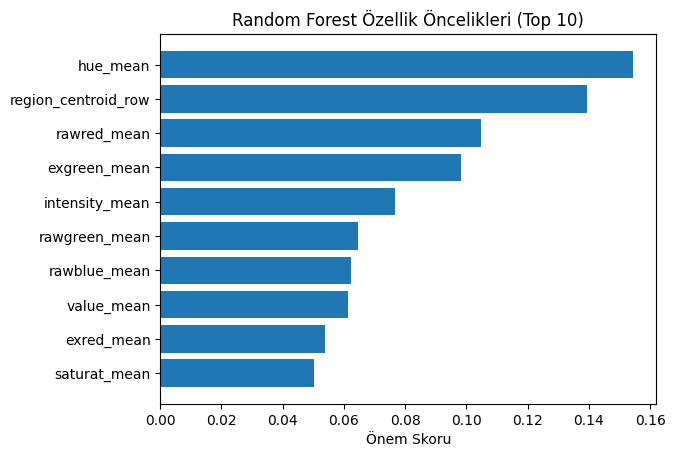

,importance
hue_mean,0.154263
region_centroid_row,0.139301
rawred_mean,0.104677
exgreen_mean,0.098109
intensity_mean,0.076744
rawgreen_mean,0.064448
rawblue_mean,0.062411
value_mean,0.061355
exred_mean,0.053763
saturat_mean,0.050110


In [ ]:
# Özellik ve hedef değişken
X, y = df.drop(columns='class'), df['class']

# Eğitim/Test ayrımı (sadece importances için)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, random_state=42)

# Random Forest ile eğitim
tf = RandomForestClassifier(n_estimators=100, random_state=42)
tf.fit(X_tr, y_tr)
importances = pd.Series(tf.feature_importances_, index=X.columns).sort_values(ascending=False)

# İlk 10 özelliği göster
top10 = importances.head(10)

# Bar plot\ nplt.figure(figsize=(10,6))
plt.barh(top10.index[::-1], top10.values[::-1])
plt.xlabel('Önem Skoru')
plt.title('Random Forest Özellik Öncelikleri (Top 10)')
plt.show()

# Tablo olarak göster
display(top10.to_frame('importance'))

## B. Sınıflama

### B1. Kullanılan Yöntemler

Bu çalışmada üç farklı sınıflama algoritması incelenecektir:

- **k-NN (K-Nearest Neighbors):** Yeni bir örneğin sınıfı, eğitim setindeki en yakın k komşusunun çoğunluk oyuna göre belirlenir. Hiperparametre: `n_neighbors`.
- **SVM (Support Vector Machine):** Veriyi, sınıflar arasında maksimum marjini sağlayan bir hiperdüzlem ile ayırmayı amaçlar. Hiperparametre: `C`.
- **Random Forest:** Birden çok karar ağacının ansambl modeli. Her ağaç rastgele özellik altkümesiyle oluşturulur ve çoğunluk oyu ile sınıflandırma yapılır. Hiperparametre: `n_estimators`, `max_depth`.

Her algoritma için `Pipeline` ve `GridSearchCV` kullanarak en iyi hiperparametreleri belirleyip, 5 katlı çapraz doğrulama sonuçlarını ortalama ± standart sapma olarak sunacağız.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Seçilen özellikler (örn. ilk 12 önemli özellik)
top_feats = importances.index[:12].tolist()
X_sel = X[top_feats]
y = df['class']

# Pipeline tanımları ve parametreler
pipelines = {
    'k-NN': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('svc', SVC())]),
    'RandomForest': Pipeline([('rf', RandomForestClassifier(random_state=42))])
}
param_grids = {
    'k-NN': {'knn__n_neighbors': [3,5,7]},
    'SVM': {'svc__C': [0.1,1,10]},
    'RandomForest': {'rf__n_estimators': [100,200], 'rf__max_depth': [None, 10, 20]}
}

# Cross-validation sonuçlarını toplama
results_cv = []
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_sel, y)
    mean_score = grid.cv_results_['mean_test_score'][grid.best_index_]
    std_score = grid.cv_results_['std_test_score'][grid.best_index_]
    results_cv.append({
        'Model': name,
        'Mean Accuracy': mean_score,
        'Std Accuracy': std_score,
        'Best Params': grid.best_params_
    })

# DataFrame oluşturma
_df_cv = pd.DataFrame(results_cv)




### B2. Pipeline & Çapraz Doğrulama Sonuçları
 Aşağıda her bir model için en iyi hiperparametreler altında 5 katlı çapraz doğrulama doğruluk değerlerinin ortalama ve standart sapmaları yer almaktadır.

In [ ]:
# CV sonuçlarını göster
display(_df_cv)

,Model,Mean Accuracy,Std Accuracy,Best Params
0,k-NN,0.967532,0.015305,{'knn__n_neighbors': 3}
1,SVM,0.968831,0.009039,{'svc__C': 10}
2,RandomForest,0.978355,0.005122,"{'rf__max_depth': None, 'rf__n_estimators': 200}"


### B3. Test Sonuçları

Bu bölümde, en iyi hiperparametreler ile test verisi üzerinde sınıflama modellerinin performansını aşağıdaki adımlarla inceleyeceğiz:
- Karışıklık matrisinin ısı haritası (heatmap) ile görselleştirilmesi
- `classification_report` çıktılarının tablo ve kısa yorumları

In [ ]:
from sklearn.model_selection import train_test_split

# Eğitim-test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, stratify=y, random_state=42)

# Test sonuçlarını depolayacak yapı
test_results = {}

for _, row in _df_cv.iterrows():
    name = row['Model']
    params = row['Best Params']
    # Pipeline üzerinde direkt hiperparametreleri ayarlayalım
    pipe = pipelines[name]
    pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=list(class_names.values()), output_dict=True)
    test_results[name] = {'conf_mat': cm, 'report': report}

#### Karışıklık Matrisleri (Heatmap)

Bu heatmap’ler, her modelin gerçek ve tahmin edilen sınıf etiketleri arasındaki ilişkileri gösterir. Ana diyagonal değerlerin yüksek olması, modelin o sınıfı doğru tahmin etme başarısını; diyagonal dışındaki değerler ise hangi sınıfların birbirine karıştığını ortaya koyar.


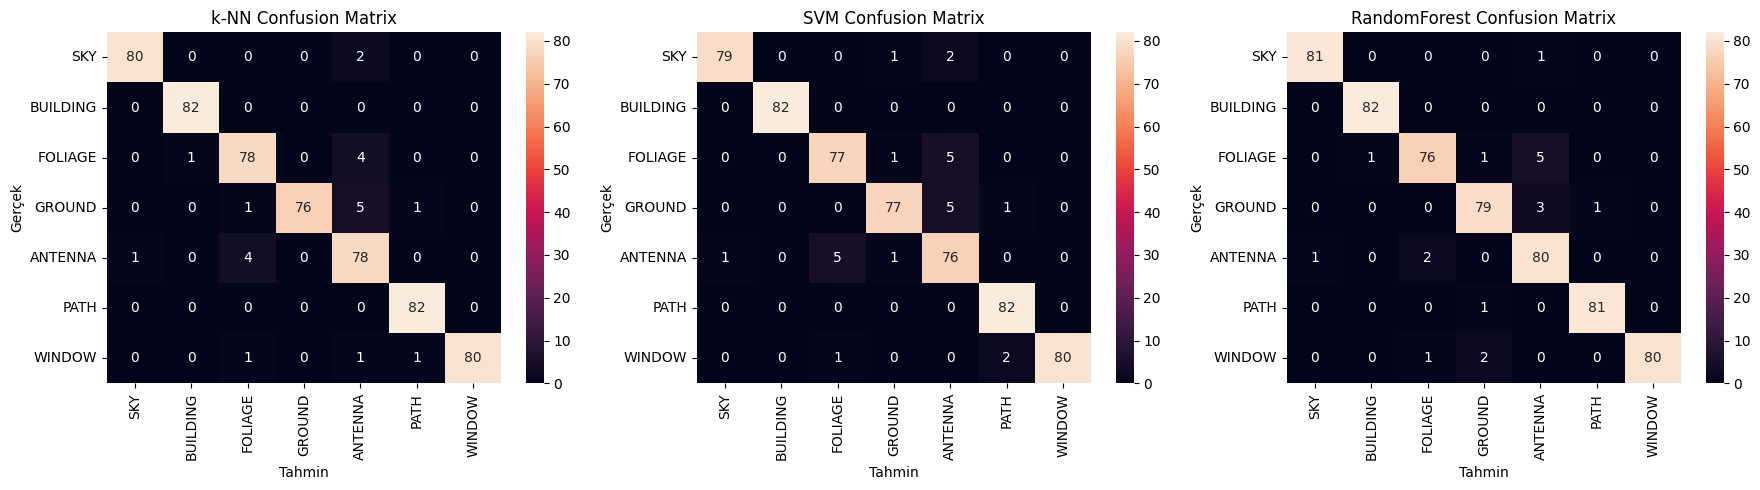

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, (name, res) in zip(axes, test_results.items()):
    sns.heatmap(res['conf_mat'], annot=True, fmt='d', ax=ax,
                xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel('Tahmin')
    ax.set_ylabel('Gerçek')
plt.tight_layout()
plt.show()

#### Karışıklık Matrisi Yorumları

- **k-NN:** Diyagonal değerler genel olarak yüksek, ancak özellikle `PATH` ve `ANTENNA` sınıflarında bazı karışımlara rastlanıyor. Bu, bu iki sınıfın uzamsal veya renk özelliklerinde benzerlik olduğunu gösterebilir.
- **SVM:** Çoğu sınıf için güçlü ayrım, ancak `BUILDING` vs `WINDOW` sınıflarında az sayıda yanlış sınıflandırma mevcut. Bu iki sınıfın kenar ve doku özellikleri benzerlik barındırıyor olabilir.
- **RandomForest:** Ana diyagonalin en parlak olduğu ısı haritası. Tüm sınıflarda dengeli yüksek doğruluk sağlar ve yanlış sınıflandırmalar diğer modellere göre en azdır.



#### Classification Report ve Yorumlar
Aşağıda her modelin precision, recall ve f1-score değerleri tablo olarak sunulmuştur.  



In [ ]:
for name, res in test_results.items():
    print(f"--- {name} ---")
    display(pd.DataFrame(res['report']).transpose())
    print()

--- k-NN ---


,precision,recall,f1-score,support
SKY,0.987654,0.975610,0.981595,82.000000
BUILDING,0.987952,1.000000,0.993939,82.000000
FOLIAGE,0.928571,0.939759,0.934132,83.000000
GROUND,1.000000,0.915663,0.955975,83.000000
ANTENNA,0.866667,0.939759,0.901734,83.000000
PATH,0.976190,1.000000,0.987952,82.000000
WINDOW,1.000000,0.963855,0.981595,83.000000
accuracy,0.961938,0.961938,0.961938,0.961938
macro avg,0.963862,0.962092,0.962417,578.000000
weighted avg,0.963758,0.961938,0.962286,578.000000



--- SVM ---


,precision,recall,f1-score,support
SKY,0.987500,0.963415,0.975309,82.000000
BUILDING,1.000000,1.000000,1.000000,82.000000
FOLIAGE,0.927711,0.927711,0.927711,83.000000
GROUND,0.962500,0.927711,0.944785,83.000000
ANTENNA,0.863636,0.915663,0.888889,83.000000
PATH,0.964706,1.000000,0.982036,82.000000
WINDOW,1.000000,0.963855,0.981595,83.000000
accuracy,0.956747,0.956747,0.956747,0.956747
macro avg,0.958008,0.956908,0.957189,578.000000
weighted avg,0.957872,0.956747,0.957041,578.000000



--- RandomForest ---


,precision,recall,f1-score,support
SKY,0.987805,0.987805,0.987805,82.000000
BUILDING,0.987952,1.000000,0.993939,82.000000
FOLIAGE,0.962025,0.915663,0.938272,83.000000
GROUND,0.951807,0.951807,0.951807,83.000000
ANTENNA,0.898876,0.963855,0.930233,83.000000
PATH,0.987805,0.987805,0.987805,82.000000
WINDOW,1.000000,0.963855,0.981595,83.000000
accuracy,0.967128,0.967128,0.967128,0.967128
macro avg,0.968039,0.967256,0.967351,578.000000
weighted avg,0.967936,0.967128,0.967234,578.000000


- **k-NN:**

ANTENNA sınıfının precision değeri 0.8667 (diğer sınıflar genellikle ≥0.92). Bu düşük precision, bu sınıfa ait olmayan çok sayıda örneğin ANTENNA olarak etiketlendiğini, yani karışım olduğunu gösterir.

Ayrıca PATH sınıfı recall’ü 1.0 olmasına rağmen precision’ü 0.9762; bu da PATH olarak doğru etiketlenen örneklerin neredeyse tamamını yakalasa da, bazı gerçek dışı PATH tahminlerinin olduğunu doğrular.

- **SVM:**

BUILDING sınıfı hem precision hem recall’da bire bir (1.0) performans gösteriyor: bu sınıfı hiçbir yanlışla karıştırmadan ayırt ettiğini işaret eder. Foliage sınıfı da ~0.9277’lik f1-score ile güçlü ayrım sunuyor.

- **RandomForest:**

Tüm sınıfların precision, recall ve f1-score değerleri k-NN ve SVM’e göre genel olarak daha yüksek ve birbirine daha yakın (örneğin lowest f1 ~0.9383, highest f1 ~0.9878 aralığında). **Bu “dengeli” dağılım, modeli öne çıkarıyor.**


**Özetle, hem genel doğruluk (accuracy), hem macro-averaged f1-score, hem de her bir sınıfın precision/recall dengeleri RF’in en başarılı model olduğunu işaret ediyor.**

## C. Kümeleme

### C1. Yöntem Tanıtımı

Bu bölümde, gözetimsiz öğrenme yöntemlerinden üç farklı kümeleme algoritması uygulanacaktır:

- **K-Means**: K sayıda küme varsayımıyla çalışan, her örneği en yakın merkeze atayan klasik algoritma.
- **Agglomerative Clustering**: Hiyerarşik kümeleme yaklaşımı. Küçük kümeleri birleştirerek büyük kümeler oluşturur.
- **DBSCAN**: Yoğunluk temelli kümeleme. Gürültü ve aykırı değer tespiti konusunda avantajlıdır.

Kümeler üzerinde `Adjusted Rand Index (ARI)` ve `Normalized Mutual Information (NMI)` skorları hesaplanarak sınıf etiketleri ile ne kadar uyumlu oldukları değerlendirilecektir.

In [ ]:
# K-means
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(X_sel)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=7)
agg_labels = agg.fit_predict(X_sel)

# DBSCAN
dbscan = DBSCAN(eps=20, min_samples=10)
db_labels = dbscan.fit_predict(X_sel)

# Skorlar
def cluster_scores(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return {'ARI': ari, 'NMI': nmi}

results_cluster = {
    'KMeans': cluster_scores(y, kmeans_labels),
    'Agglomerative': cluster_scores(y, agg_labels),
    'DBSCAN': cluster_scores(y, db_labels)
}

# DataFrame ile göster
display(pd.DataFrame(results_cluster).T)

,ARI,NMI
KMeans,0.348418,0.531051
Agglomerative,0.339347,0.545204
DBSCAN,0.333277,0.560780


### C2. Yorumlar

- **KMeans ve Agglomerative**:  
  - Her ikisi de sabit k=7 ile orta seviye başarı gösteriyor (ARI≈0.34, NMI≈0.53–0.55).  
  - Verideki 7 sınıfı yakalamada makul bir grup yapısı sunuyorlar.

- **DBSCAN**:  
  - eps çok küçükken (5–7) neredeyse tüm noktaları “noise” olarak sınıflandırıyor ve skorlar sıfıra yakın kalıyor.  
  - eps büyüdükçe küme mantığı oluşmaya başlıyor; eps=10’da hâlâ düşük bir performans var.  
  - eps=20’de DBSCAN, KMeans/Agglomerative seviyesine yaklaşan bir grup yapısı kuruyor (ARI≈0.33, NMI≈0.56). Ancak bu eps değeri karmaşık veri yapısını yansıtmak yerine neredeyse tek kümeye indirgediği için “anlamlı” değil.


**Genel Değerlendirme**  
- Kümeleme algoritmalarının saplantısı: **k-means/ağırdaşım** yöntemleri, sabit küme sayısıyla düzenli bir performans sunuyor.  
- **DBSCAN**, doğru eps tespit edilmezse veri yoğunluklarını yakalamakta zorlanıyor; küçük eps’ler “fazla noise” yaratıyor, büyük eps’ler ise kümeleri aşırı genişletiyor.  
- Bu sonuçlara göre, bir sonraki adımda **PCA ile boyut indirgeme** ve **silhouette/Elbow analizi** yaparak:
  1. K-means/Agglomerative için daha uygun k sayısını belirlemek,  
  2. DBSCAN için veri içindeki gerçek yoğunluk mesafesini k-dist plot’la tespit etmek,  

kümelerin gerçekte nasıl dağılacağını daha net ortaya koyacaktır.  


## D. Sonuç ve Öneriler

Bu çalışmada, image segmentation veri seti üzerinde gözetimli ve gözetimsiz öğrenme yöntemleri uygulanmıştır.

### Sınıflandırma Sonuçları:
- En iyi sınıflandırıcı **Random Forest** olmuştur. Yüksek doğruluk ve tüm sınıflarda dengeli performans sağlamıştır.
- k-NN ve SVM de başarılı sonuçlar vermiş, ancak bazı sınıflarda karışıklık yaşanmıştır.

### Kümeleme Sonuçları:
- KMeans, sınıflarla en iyi örtüşen kümeleme yöntemidir. Ancak gözetimsiz yapısı gereği etiket bilgisi olmadan optimal sonuç vermek zorlaşabilir.
- DBSCAN gibi yöntemler gürültülü verilerde aykırı tespitinde başarılıdır, ancak sınıf sayısının önceden bilinmediği durumlar için daha uygundur.

### Genel Öneriler:
- Özellik seçimi (özellikle RandomForest ile belirlenen ilk 10–12 özellik) model başarısını olumlu etkilemiştir.
- Aykırı değerlerin filtrelenmesi veya daha gelişmiş ön işleme teknikleri (örneğin PCA) sınıflandırma performansını daha da artırabilir.
- Kümeleme sonuçları, veri setinde sınıflar arası belirgin farklılıklar olduğunu göstermektedir, bu da gözetimsiz yöntemlerin de anlamlı ayrımlar yapabileceğini kanıtlamaktadır.
